In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ast import literal_eval
import warnings as warn
warn.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_distances

In [106]:
movies=pd.read_csv('tmdb_5000_movies.csv')
credits=pd.read_csv('tmdb_5000_credits.csv')
movies=movies.merge(credits,on='title')
movies.head(1).columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'movie_id', 'cast', 'crew'],
      dtype='object')

In [107]:
movies.isna().sum()
movies.dropna(inplace=True)
print(f"Columns with the missing values\n {movies.isna().sum()}")
print(f"Columns with the duplicated values\n {movies.duplicated().sum()}")

Columns with the missing values
 budget                  0
genres                  0
homepage                0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
movie_id                0
cast                    0
crew                    0
dtype: int64
Columns with the duplicated values
 0


In [108]:
year=movies['release_date']
year=year.astype('datetime64')
year=year.map(lambda x:[str(x.year)])

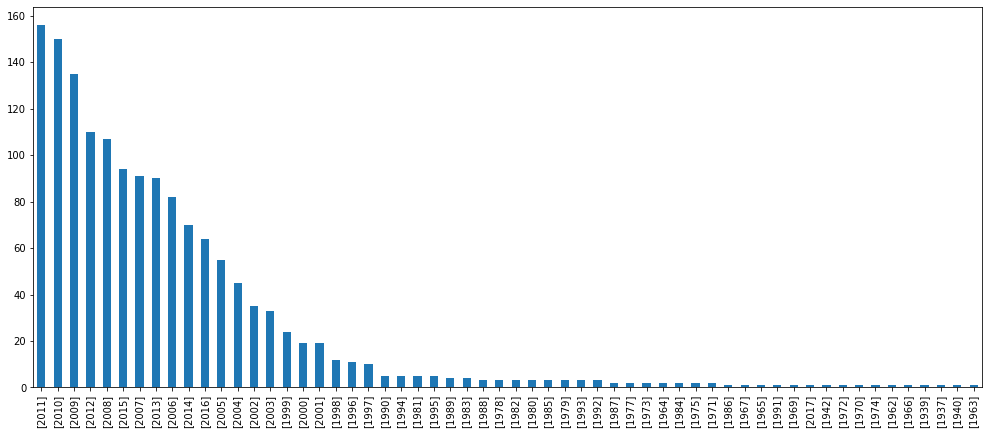

In [109]:
year.value_counts().plot(kind='bar',figsize=(17,7));

In [110]:
## Keeping columns that are of more significance to us for getting a recommendation
# genres 
# id
# keywords
# title
# overview
# cast
# crew
movies=movies[['genres','id','keywords','title','overview','cast','crew']]
movies=pd.concat([movies,year],axis=1)
movies.head()

,genres,id,keywords,title,overview,cast,crew,release_date
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",[2009]
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",[2007]
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",Spectre,A cryptic message from Bond’s past sends him o...,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",[2015]
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",[2012]
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",John Carter,"John Carter is a war-weary, former military ca...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",[2012]


In [111]:
# Get Keywords for each movie
def convert_to_tags(keywords):
    l=[]
    for i in literal_eval(keywords):
        l.append(i['name'])
    return l
def get_directors(crew):
    l=[]
    for j in literal_eval(crew):
        if j['job']=='Director':
            l.append(j['name'])
    return l    
movies['genres']=movies['genres'].apply(convert_to_tags)
movies['cast']=movies['cast'].apply(convert_to_tags)
movies['keywords']=movies['keywords'].apply(convert_to_tags)
movies['crew']=movies['crew'].apply(get_directors)

#Getting Top 3 actors from the cast list
movies['cast']=movies['cast'].apply(lambda x:x[0:3])
movies['overview']=movies['overview'].apply(lambda x:x.split())

In [112]:
movies.head()

,genres,id,keywords,title,overview,cast,crew,release_date
0,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],[2009]
1,"[Adventure, Fantasy, Action]",285,"[ocean, drug abuse, exotic island, east india ...",Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],[2007]
2,"[Action, Adventure, Crime]",206647,"[spy, based on novel, secret agent, sequel, mi...",Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],[2015]
3,"[Action, Crime, Drama, Thriller]",49026,"[dc comics, crime fighter, terrorist, secret i...",The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],[2012]
4,"[Action, Adventure, Science Fiction]",49529,"[based on novel, mars, medallion, space travel...",John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],[2012]


In [113]:
# Concatting all of the Key words to make a tag for identifying the movies
movies['keywords']=movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x])
movies['genres']=movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['cast']=movies['cast'].apply(lambda x:[i.replace(" ","") for i in x])
movies['crew']=movies['crew'].apply(lambda x:[i.replace(" ","") for i in x])
movies['overview']=movies['overview'].apply(lambda x:[i.replace(" ","") for i in x])

In [114]:
movies.head()

,genres,id,keywords,title,overview,cast,crew,release_date
0,"[Action, Adventure, Fantasy, ScienceFiction]",19995,"[cultureclash, future, spacewar, spacecolony, ...",Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],[2009]
1,"[Adventure, Fantasy, Action]",285,"[ocean, drugabuse, exoticisland, eastindiatrad...",Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],[2007]
2,"[Action, Adventure, Crime]",206647,"[spy, basedonnovel, secretagent, sequel, mi6, ...",Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],[2015]
3,"[Action, Crime, Drama, Thriller]",49026,"[dccomics, crimefighter, terrorist, secretiden...",The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],[2012]
4,"[Action, Adventure, ScienceFiction]",49529,"[basedonnovel, mars, medallion, spacetravel, p...",John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],[2012]


In [115]:
#concatting all of the features in a column as "Tags"
movies['Tags']=movies['overview']+movies['keywords']+movies['genres']+movies['cast']+movies['crew']

In [116]:
movies.head()

,genres,id,keywords,title,overview,cast,crew,release_date,Tags
0,"[Action, Adventure, Fantasy, ScienceFiction]",19995,"[cultureclash, future, spacewar, spacecolony, ...",Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],[2009],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,"[Adventure, Fantasy, Action]",285,"[ocean, drugabuse, exoticisland, eastindiatrad...",Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],[2007],"[Captain, Barbossa,, long, believed, to, be, d..."
2,"[Action, Adventure, Crime]",206647,"[spy, basedonnovel, secretagent, sequel, mi6, ...",Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],[2015],"[A, cryptic, message, from, Bond’s, past, send..."
3,"[Action, Crime, Drama, Thriller]",49026,"[dccomics, crimefighter, terrorist, secretiden...",The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],[2012],"[Following, the, death, of, District, Attorney..."
4,"[Action, Adventure, ScienceFiction]",49529,"[basedonnovel, mars, medallion, spacetravel, p...",John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],[2012],"[John, Carter, is, a, war-weary,, former, mili..."


In [117]:
#Creating final dataframe for recommendation system
df_new=movies[['id','title','Tags']]
df_new['Tags']=df_new['Tags'].apply(lambda x:" ".join(x))

In [118]:
#Converting Tags to lower case
df_new['Tags']=df_new['Tags'].apply(lambda x:x.lower())
df_new.head()

,id,title,Tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


In [161]:
movies[movies['title']=='Spectre']['id'].values[0]

206647

In [120]:
#Removing the repeated words
ps=PorterStemmer()
def get_base_word(text):
    l=[]
    for i in text.split():
        l.append(ps.stem(i))
    return " ".join(l)
df_new['Tags']=df_new['Tags'].apply(get_base_word)    

In [142]:
cv=CountVectorizer(max_features=15000,stop_words='english',analyzer='word',min_df=0.0)
vectors=cv.fit_transform(df_new['Tags']).toarray()

In [143]:
cv.get_feature_names()

['00',
 '000',
 '007',
 '10',
 '100',
 '1000',
 '101',
 '108',
 '10th',
 '11',
 '117',
 '11th',
 '12',
 '13',
 '14',
 '1408',
 '15',
 '150',
 '15th',
 '16',
 '1630s',
 '17',
 '1748',
 '17th',
 '17thcenturi',
 '18',
 '1800',
 '1818',
 '1820',
 '1820s',
 '1831',
 '1845',
 '1856',
 '1863',
 '1885',
 '1890',
 '18th',
 '18thcenturi',
 '19',
 '1905',
 '1910',
 '1912',
 '1919',
 '1920',
 '1926',
 '1927',
 '1929',
 '1930',
 '1937',
 '1940',
 '1942',
 '1944',
 '1945',
 '1949',
 '1950',
 '1950s',
 '1952',
 '1955',
 '1957',
 '1958',
 '1959',
 '1960',
 '1960s',
 '1962',
 '1964',
 '1965',
 '1967',
 '1969',
 '1970',
 '1970s',
 '1972',
 '1973',
 '1974',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1980s',
 '1981',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1990',
 '1991',
 '1992',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '19th',
 '19thcenturi',
 '20',
 '200',
 '2000',
 '2000ad',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '20

In [144]:
vector_distance=cosine_distances(vectors)

In [146]:
def recommend_movies(movie):
    movie_index=df_new[df_new['title']==movie].index[0]
    distance=vector_distance[movie_index]
    movie_similarity_list=sorted(list(enumerate(distance)),reverse=True,key=lambda x:x[1])[1:6]
    for i in movie_similarity_list:
        print(df_new.iloc[i[0]].title)

recommend_movies("Jason Bourne")

Edge of Tomorrow
Dawn of the Planet of the Apes
The Curious Case of Benjamin Button
The Wolfman
Spider-Man


In [147]:
import pickle

In [148]:
pickle.dump(df_new,open('movies.pkl','wb'))

In [149]:
pickle.dump(vector_distance,open('vector_distance.pkl','wb'))